<a href="https://colab.research.google.com/github/lizjwh/groupIAI_5take2/blob/main/3%20Testing%20on%20Original%20Model/Testing3_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test script
This notebook will test the OGmodel on the full and restricted mobility datasets.


In [ ]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle
!pip install tqdm
!pip install colorama

In [ ]:
#import  needed libraries and check the used gpu
import torch
from torch import nn, optim, tensor
from torchvision import transforms, models ,datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Test the model on our restricted mobility dataset
First, import dataset from Emily's kaggle

In [ ]:
! export KAGGLE_USERNAME="emmet454" && export KAGGLE_KEY="ee00fbc0728a71f5c5f712029e3ef004" && kaggle datasets download --force --unzip emilyburt/intro-to-ai

100% 4.08G/4.08G [02:34<00:00, 39.6MB/s]
100% 4.08G/4.08G [02:34<00:00, 28.3MB/s]


In [ ]:
print("File path and subfolders")
! pwd && ls
print("\nFolders and files in the Dataset directory:")
! cd Dataset && ls

File path and subfolders
/content
Dataset  sample_data

Folders and files in the Dataset directory:
'Full Mobility'  'Restricted mobility'


Set up the model with 29 classes (this block is copied from tutorial)

In [ ]:
model = models.mobilenet_v2(pretrained=True)
# Freeze parameters of the tarined network
for param in model.parameters():
    param.requires_grad = False
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True


# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 149MB/s]


Load the OG model - you must make sure the OGModelWeights file is uploaded to the current Colab session


In [ ]:
!git clone https://github.com/lizjwh/groupIAI_5take2
device = torch.device("cuda")
model.load_state_dict(torch.load('groupIAI_5take2/OGModelWeights.pth'))
model.to(device)
model.eval()

Cloning into 'groupIAI_5take2'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 190 (delta 1), reused 2 (delta 0), pack-reused 181
Receiving objects: 100% (190/190), 44.47 MiB | 5.71 MiB/s, done.
Resolving deltas: 100% (74/74), done.


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Create array of all images from restricted mobility and display the first image.



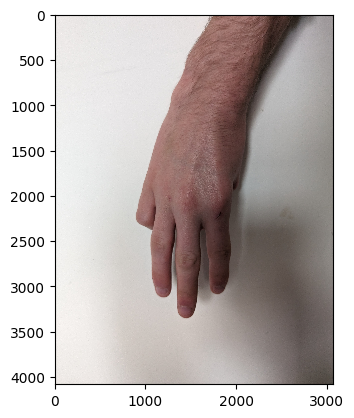

In [ ]:
Restricted_ASL=np.array(glob.glob('/content/Dataset/Restricted mobility/*/*/*'))
#print(Restricted_ASL)
im = plt.imread(Restricted_ASL[0]) #they seem to be rotated
plt.imshow(im,interpolation='nearest')
plt.show()

Let's create a dataloader

In [29]:

def rename_folder(folder_path, new_name):
    """
    Rename a folder.

    Args:
    - folder_path (str): Path to the folder to be renamed.
    - new_name (str): New name for the folder.
    """
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return

    # Extract the directory path and folder name
    directory, old_name = os.path.split(folder_path)

    # Create the new path with the new folder name
    new_path = os.path.join(directory, new_name)

    try:
        # Rename the folder
        os.rename(folder_path, new_path)
        print(f"Folder '{folder_path}' renamed to '{new_path}'.")
    except OSError as e:
        print(f"Error: Failed to rename folder '{folder_path}' to '{new_path}': {e}")


folder_path = "/content/Dataset/Full Mobility/Left hand/Space"
new_name = "space"
rename_folder(folder_path, new_name)

folder_path = "/content/Dataset/Full Mobility/Right hand/Space"
rename_folder(folder_path, new_name)

folder_path = "/content/Dataset/Restricted mobility/Left hand/Space"
rename_folder(folder_path, new_name)

folder_path = "/content/Dataset/Restricted mobility/Right hand/Space"
rename_folder(folder_path, new_name)


#These functions allow each folder to be combined
from torch.utils.data import ConcatDataset

def create_dataset(root_dir):
    """
    Creates an ImageFolder dataset from the specified root directory.
    """
    # data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                          #transforms.ToTensor(),
                                          #transforms.Normalize([0.485, 0.456, 0.406],
                                                               #[0.229, 0.224, 0.225])])
    data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          ])
    dataset = datasets.ImageFolder(root_dir, transform=data_transforms)
    return dataset

def combine_datasets(root_folders):
    """
    Combines datasets from multiple root folders into one dataset.
    """
    datasets = [create_dataset(folder) for folder in root_folders]
    combined_dataset = ConcatDataset(datasets)

    # Define the desired order of classes
    class_order = ['A', 'B', 'C', 'D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','Space']   # Define your desired order
    # Extract class-to-index mappings from individual datasets and merge them
    class_to_idx = {}
    idx = -78
    for dataset in datasets:
        for class_name in class_order:
            if class_name in dataset.class_to_idx:
              if class_name == 'space':
                class_to_idx[class_name] = 28
                idx += 1
              else:
                class_to_idx[class_name] = idx
                idx += 1

    return combined_dataset, class_to_idx


def main():
    # Choose which folders to include in test here
    root_folders = ['/content/Dataset/Restricted mobility/Left hand',
                    '/content/Dataset/Restricted mobility/Right hand',
                    '/content/Dataset/Full Mobility/Left hand',
                    '/content/Dataset/Full Mobility/Right hand']

    combined_dataset, combined_class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_class_to_idx}")
    return combined_dataset, combined_class_to_idx

combined_dataset, combined_dataset.class_to_idx = main()



#define the transform for the dataset
#test_transforms = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
 #                                                           [0.229, 0.224, 0.225])])

#transform the data
#test_data = datasets.ImageFolder(path,test_transforms)
#path = '/content/Dataset/Restricted mobility/Right hand'
#test_data.append(datasets.ImageFolder(path,test_transforms))
#path = '/content/Dataset/Full Mobility/Left hand'
#test_data.append(datasets.ImageFolder(path,test_transforms))
#path = '/content/Dataset/Full Mobility/Right hand'
#test_data.append(datasets.ImageFolder(path,test_transforms))
#print(f"class to index mapping: {test_data.class_to_idx}")

#load some of the test data
testloader = torch.utils.data.DataLoader(combined_dataset, batch_size=50, shuffle=True)
images, labels = next(iter(testloader))
print(labels)
#print(images.size())

Error: Folder '/content/Dataset/Full Mobility/Left hand/Space' does not exist.
Error: Folder '/content/Dataset/Full Mobility/Right hand/Space' does not exist.
Error: Folder '/content/Dataset/Restricted mobility/Left hand/Space' does not exist.
Error: Folder '/content/Dataset/Restricted mobility/Right hand/Space' does not exist.
Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
tensor([10,  9,  6, 13, 22, 21, 13, 15, 16,  5, 11, 26, 14, 12, 25, 15, 23, 24,
        12,  0,  3,  4,  1, 19, 10, 23, 25, 22, 24, 16, 19, 16, 23, 13, 19, 17,
        11,  6, 17,  2,  8, 24, 19, 24,  0, 13, 26, 14, 15, 14])


Use model to make prediction on image

image number 26
---------------------
label: Z
prediction letter: Z


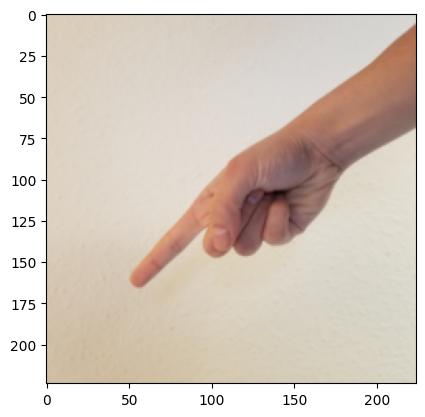

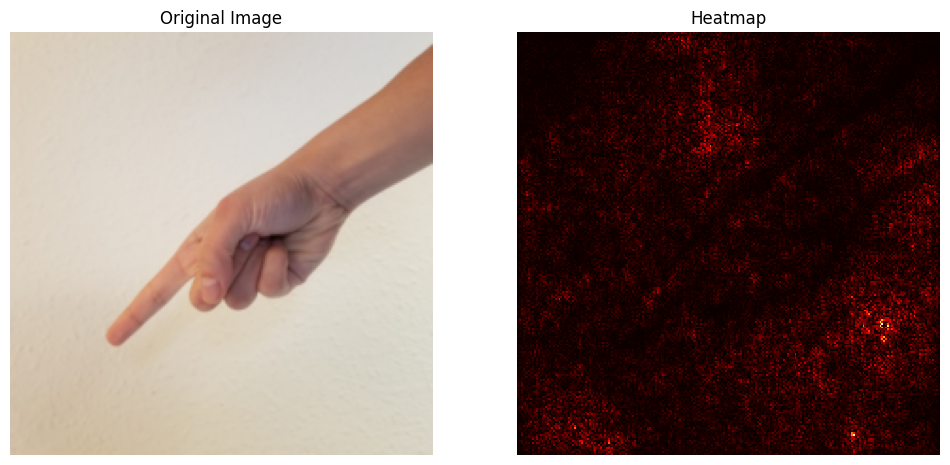

Predicted letter: Z


In [37]:
#select random image from 0-batch_size
index = np.random.randint(0,49)
test_img = images[index]
t = transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
#t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
#test_img=t_n(test_img).unsqueeze(0).cuda()
test_img = test_img.unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))
#print("res:",res)
#invert class_to_idx keys to values and viceversa.
classes = combined_dataset.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
#print("prediction index:",res.argmax().item())
print("prediction letter:", classes[res.argmax().item()])




# Assuming 'model' is your neural network model
# Get the gradients of the output with respect to the input image
test_img.requires_grad = True
output = model(test_img)
output_class = torch.argmax(output)
output[0, output_class].backward()

# Get the gradients from the input image
gradients = test_img.grad.detach().squeeze(0)

# Take the average gradient across the channels
weights = torch.mean(gradients, dim=0)

# Normalize the gradient values to be between 0 and 1
weights = torch.abs(weights) / torch.max(torch.abs(weights))

# Convert the tensor to a numpy array
heatmap = weights.cpu().numpy()

# Plot the original image and heatmap side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
axes[0].imshow(transforms.ToPILImage()(test_img.squeeze(0).cpu()))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot heatmap
axes[1].imshow(heatmap, cmap='hot', interpolation='nearest')
axes[1].set_title('Heatmap')
axes[1].axis('off')

plt.show()

# Print the predicted class
print("Predicted letter:", classes[res.argmax().item()])


Test accuracy : 15.637860082304528 %


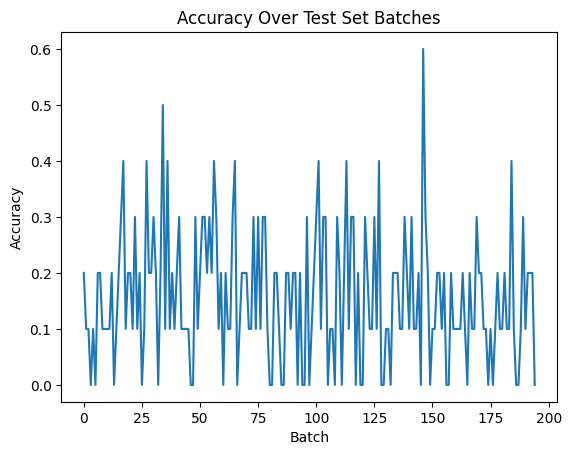

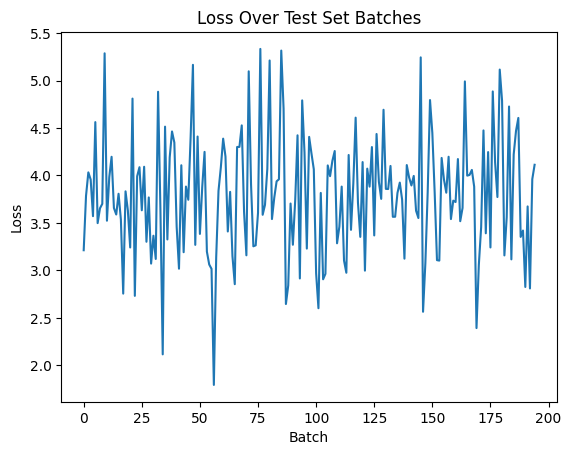

1944


In [ ]:


# Check whether we have a GPU.  Use it if we do.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loader = torch.utils.data.DataLoader(dataset=combined_dataset,
                                          batch_size=10,
                                          shuffle=True)


def test(epoch):
    # Do one pass over the test data.
    # In the test phase, don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0
        accuracies = []
        losses = []
        for images, labels in test_loader:
            #Convert image pixels to vector
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images).squeeze((-1, -2))

            # Calculate loss
            loss = criterion(logits, labels)
            losses.append(loss.item())  # Append the loss to the list

            # Compute total correct so far
            predicted = torch.argmax(logits, -1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Calculate accuracy for the current batch
            batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracies.append(batch_accuracy)

        print(f'Test accuracy : {100 * correct / total} %')

        # Plot accuracy graph
        plt.plot(accuracies)
        plt.title('Accuracy Over Test Set Batches')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.show()

        # Plot loss graph
        plt.plot(losses)
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Loss Over Test Set Batches')
        plt.show()


    return total

# Run training
total = test(1)
print(total)
